In [27]:
import pandas as pd
import importlib
import seaborn as sns
import preprocessing

from models import vader_sa as vader
from models import afinn_sa as afinn
import utils
import numpy as np

importlib.reload(utils)


<module 'utils' from '/Users/venugopalbhatia/Documents/Computational Methods for Informatics/Assignments/Project/utils.py'>

In [64]:
data_df = pd.read_csv("./data/Corona_Tweet_Data_processed.csv",parse_dates=['TweetAt'],index_col = 0,dtype={'UserName': 'str', 'ScreenName': 'str','Location':'str'},converters={"message_tokens_lemmatized": lambda x: x.strip("[]").replace("'","").split(", "),"message_tokenized": lambda x: x.strip("[]").replace("'","").split(", "),"mentions":lambda x: x.strip("[]").replace("'","").split(", ")})

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [36]:
data_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,retweeted_from,mentions,hashtags,links,...,message_tokens_lemmatized,Sentiment_numerical,vader_dict,vader_neg,vader_neu,vader_pos,vader_compound,afinn_score,lemmatized_message,Tweet_Length
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,[],"['MeNyrbie', 'Phil_Gahan', 'Chrisitv']",[],"['https://t.co/iFz9FAn2Pa', 'https://t.co/xX6g...",...,[],0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0,NaN,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,[],[],[],[],...,"[advice, talk, neighbour, family, exchange, ph...",1.0,"{'neg': 0.0, 'neu': 0.923, 'pos': 0.077, 'comp...",0.000,0.923,0.077,0.2500,1.0,advice talk neighbour family exchange phone nu...,187
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,[],[],[],['https://t.co/bInCA9Vp8P'],...,"[coronavirus, australia, woolworths, give, eld...",1.0,"{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'comp...",0.000,0.812,0.188,0.4588,0.0,coronavirus australia woolworths give elderly ...,99
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,[],[],"['COVID19france', 'COVID_19', 'COVID19', 'coro...",['https://t.co/zrlG0Z520j'],...,"[food, stock, one, empty, please, panic, enoug...",1.0,"{'neg': 0.101, 'neu': 0.735, 'pos': 0.164, 'co...",0.101,0.735,0.164,0.4824,0.0,food stock one empty please panic enough food ...,174
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,[],[],"['COVID19', 'coronavirus', 'CoronavirusFrance'...",['https://t.co/usmuaLq72n'],...,"[ready, go, supermarket, covid19, outbreak, pa...",-2.0,"{'neg': 0.238, 'neu': 0.669, 'pos': 0.093, 'co...",0.238,0.669,0.093,-0.7506,-7.0,ready go supermarket covid19 outbreak paranoid...,183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,[],[],"['NZ', 'COVID']",['https://t.co/cz89uA0HNp'],...,"[airline, pilot, offer, stock, supermarket, sh...",0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0,airline pilot offer stock supermarket shelf nz...,64
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,[],[],[],[],...,"[response, complaint, provide, cite, covid, 19...",-2.0,"{'neg': 0.198, 'neu': 0.802, 'pos': 0.0, 'comp...",0.198,0.802,0.000,-0.6369,-3.0,response complaint provide cite covid 19 relat...,101
41154,44953,89905,NaN,14-04-2020,You know its getting tough when @KameronWilds...,Positive,[],"['KameronWilds', 'kroger']","['coronavirus', 'toiletpaper']",[],...,"[know, get, tough, rationing, toilet, paper, c...",1.0,"{'neg': 0.078, 'neu': 0.781, 'pos': 0.141, 'co...",0.078,0.781,0.141,0.2960,2.0,know get tough rationing toilet paper coronavi...,81
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,[],[],"['coronavirus', 'COVID19', 'coronavirus']",[],...,"[wrong, smell, hand, sanitizer, start, turn, c...",0.0,"{'neg': 0.139, 'neu': 0.717, 'pos': 0.143, 'co...",0.139,0.717,0.143,0.0258,-2.0,wrong smell hand sanitizer start turn coronavi...,69


In [75]:
data_df['TweetAt'] = pd.to_datetime(data_df['TweetAt'],errors = 'coerce')

In [28]:
data_df['TweetAt'].sort_values()

25915     2020-01-04
25916     2020-01-04
25917     2020-01-04
25918     2020-01-04
25919     2020-01-04
             ...    
39210     2020-12-04
39220     2020-12-04
39063     2020-12-04
NaN              NaT
Neutral          NaT
Name: TweetAt, Length: 41159, dtype: datetime64[ns]

In [96]:
data_df['Location'] = data_df['Location'].str.strip()
locations = data_df['Location'].str.replace("[-?$&+.:;=?@#|'<>.^*()%!-]","",regex = True)

In [97]:
locations = locations.dropna()
locations = locations.str.strip()
locations = locations[(locations!='') | (locations!=",")]
locations = np.unique(locations,return_counts = True)

In [220]:
#np.save("./data/locations.npy",locations)

In [102]:
locations[0][locations[1]>10]

array(['', ',', 'Abuja', 'Abuja, Nigeria', 'Accra, Ghana',
       'Adelaide, South Australia', 'Africa', 'Alabama, USA',
       'Alberta, Canada', 'Albuquerque, NM', 'Alexandria, VA', 'America',
       'Amsterdam', 'Amsterdam, The Netherlands', 'Ann Arbor, MI',
       'Arizona', 'Arizona, USA', 'Arlington, VA', 'Asheville, NC',
       'Atlanta', 'Atlanta, GA', 'Auckland, New Zealand', 'Austin, TX',
       'Austin, Texas', 'Australia', 'Bahrain', 'Baltimore, MD',
       'Bangalore', 'Bangkok, Thailand', 'Barcelona', 'Barcelona, Spain',
       'Baton Rouge, LA', 'Bay Area, CA', 'Belfast', 'Belgium',
       'Bengaluru, India', 'Berkeley, CA', 'Berlin', 'Berlin, Germany',
       'Birmingham, England', 'Boise, ID', 'Boston', 'Boston, MA',
       'Brighton, England', 'Brisbane, Queensland', 'Bristol',
       'Bristol, England', 'British Columbia, Canada', 'Bronx, NY',
       'Brooklyn', 'Brooklyn, NY', 'Brussels', 'Brussels, Belgium',
       'Calgary', 'Calgary, Alberta', 'California', 'Cali

In [10]:
regions = ['Adelaide, South Australia', 'Bangalore', 'Barcelona', 'Barcelona, Spain', 'Baton Rouge, LA']

In [11]:
data_df[data_df['Location'].str.contains('|'.join(list(regions)),na = False)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,retweeted_from,mentions,hashtags,links,message_cleaned,message_tokenized,message_tokens_lemmatized,Sentiment_numerical,vader_dict,vader_neg,vader_neu,vader_pos,vader_compound,afinn_score
94,3893,48845,"Adelaide, South Australia",16-03-2020,Supermarket workers are at the frontline of CO...,Positive,[],[],[],['https://t.co/0uHGM8gsp8'],Supermarket workers are at the frontline of CO...,"['Supermarket', 'workers', 'frontline', 'COVID...","[supermarket, worker, frontline, covid, 19, ex...",1.0,"{'neg': 0.051, 'neu': 0.803, 'pos': 0.146, 'co...",0.051,0.803,0.146,0.5584,4.0
729,4528,49480,"Adelaide, South Australia",17-03-2020,@justinel_h As a consumer of your reporting I ...,Extremely Positive,[],['justinel_h'],[],[],As a consumer of your reporting I agree my int...,"['consumer', 'reporting', 'agree', 'interest',...","[consumer, reporting, agree, interest, primari...",2.0,"{'neg': 0.048, 'neu': 0.793, 'pos': 0.159, 'co...",0.048,0.793,0.159,0.6908,1.0
895,4694,49646,"Barcelona, Cataluña",17-03-2020,People stand in a queue to enter a supermarket...,Neutral,[],[],"['coronavirusespa', 'covid_19']",['https://t.co/ivL9tXZrtM'],People stand in a queue to enter a supermarket...,"['People', 'stand', 'queue', 'enter', 'superma...","[people, stand, queue, enter, supermarket, out...",0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,-3.0
923,4722,49674,"Bangalore, INDIA",17-03-2020,"During the time of a crisis, focus on Customer...",Extremely Negative,[],[],"['healthcare', 'Payers', 'customerengagement']",['https://t.co/RCeHXH4dGh'],During the time of a crisis focus on Customer...,"['time', 'crisis', 'focus', 'Customers', 'heal...","[time, crisis, focus, customers, healthcare, p...",-2.0,"{'neg': 0.272, 'neu': 0.728, 'pos': 0.0, 'comp...",0.272,0.728,0.000,-0.6249,-3.0
1019,4818,49770,"Baton Rouge, LA",17-03-2020,New article released today about prevalent SNA...,Positive,[],[],[],['https://t.co/vPMLJ8WPj8'],New article released today about prevalent SNA...,"['New', 'article', 'released', 'today', 'preva...","[new, article, release, today, prevalent, snap...",1.0,"{'neg': 0.126, 'neu': 0.672, 'pos': 0.202, 'co...",0.126,0.672,0.202,0.4215,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39354,43153,88105,"Barcelona, Spain",12-04-2020,#Coronavirus: #Singapore #property prices set ...,Negative,[],['scmpnews'],"['Coronavirus', 'Singapore', 'property']",['https://t.co/K3Rkuz4jZm'],Coronavirus Singapore property prices set t...,"['Coronavirus', 'Singapore', 'property', 'pric...","[coronavirus, singapore, property, price, set,...",-1.0,"{'neg': 0.194, 'neu': 0.806, 'pos': 0.0, 'comp...",0.194,0.806,0.000,-0.3400,-3.0
39420,43219,88171,Bangalore,12-04-2020,#TPE: Indian-American 7-Eleven? store owner wa...,Negative,[],[],"['TPE', 'NewJersey', 'Sanitizers', 'Coronaviru...",['https://t.co/FpscEbgD0i'],TPE Indian American 7 Eleven store owner was...,"['TPE', 'Indian', 'American', '7', 'Eleven', '...","[tpe, indian, american, 7, eleven, store, owne...",-1.0,"{'neg': 0.1, 'neu': 0.9, 'pos': 0.0, 'compound...",0.100,0.900,0.000,-0.4767,-3.0
40671,44470,89422,Bangalore,13-04-2020,Check out @Gartner_SC #podcast to better under...,Positive,[],['Gartner_SC'],"['podcast', 'COVID19', 'SupplyChain', 'Gartner...",['https://t.co/dTZxvwIBkK'],Check out podcast to better understand the ...,"['Check', 'podcast', 'better', 'understand', '...","[check, podcast, well, understand, covid19, im...",1.0,"{'neg': 0.0, 'neu': 0.888, 'pos': 0.112, 'comp...",0.000,0.888,0.112,0.4404,2.0
40864,44663,89615,Bangalore,13-04-2020,Their share prices might be lower because of t...,Extremely Positive,[],[],['machinelearning'],"['https://t.co/Kag2x7xQ20', 'https://t.co/W0r6...",Their share prices might be lower because of t...,"['share', 'prices', 'might', 'lower', 'COVID',...","[share, price, might, lower, covid, 19, outbre...",2.0,"{'neg': 0.056, 'neu': 0.5

In [22]:
Extremely_positive_subset = data_df[(data_df['Location'].str.contains('|'.join(regions))) & (data_df['Sentiment_numerical'] == 2)].groupby('TweetAt').count()

In [264]:
Extremely_positive_subset

,UserName,ScreenName,Location,OriginalTweet,Sentiment,retweeted_from,mentions,hashtags,links,message_cleaned,message_tokenized,message_tokens_lemmatized,Sentiment_numerical,vader_dict,vader_neg,vader_neu,vader_pos,vader_compound,afinn_score,lemmatized_message
TweetAt,,,,,,,,,,,,,,,,,,,,
01-04-2020,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
02-04-2020,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
03-04-2020,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
04-04-2020,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
05-04-2020,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
06-04-2020,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
07-04-2020,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
08-04-2020,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
09-04-2020,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


In [31]:
data = data_df

In [21]:
data

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,retweeted_from,mentions,hashtags,links,message_cleaned,message_tokenized,message_tokens_lemmatized,Sentiment_numerical,vader_dict,vader_neg,vader_neu,vader_pos,vader_compound,afinn_score
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,[],"['MeNyrbie', 'Phil_Gahan', 'Chrisitv']",[],"['https://t.co/iFz9FAn2Pa', 'https://t.co/xX6g...",and and,[],[],0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,[],[],[],[],advice Talk to your neighbours family to excha...,"['advice', 'Talk', 'neighbours', 'family', 'ex...","[advice, talk, neighbour, family, exchange, ph...",1.0,"{'neg': 0.0, 'neu': 0.923, 'pos': 0.077, 'comp...",0.000,0.923,0.077,0.2500,1.0
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,[],[],[],['https://t.co/bInCA9Vp8P'],Coronavirus Australia Woolworths to give elde...,"['Coronavirus', 'Australia', 'Woolworths', 'gi...","[coronavirus, australia, woolworths, give, eld...",1.0,"{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'comp...",0.000,0.812,0.188,0.4588,0.0
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,[],[],"['COVID19france', 'COVID_19', 'COVID19', 'coro...",['https://t.co/zrlG0Z520j'],My food stock is not the only one which is emp...,"['food', 'stock', 'one', 'empty', 'PLEASE', 'p...","[food, stock, one, empty, please, panic, enoug...",1.0,"{'neg': 0.101, 'neu': 0.735, 'pos': 0.164, 'co...",0.101,0.735,0.164,0.4824,0.0
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,[],[],"['COVID19', 'coronavirus', 'CoronavirusFrance'...",['https://t.co/usmuaLq72n'],Me ready to go at supermarket during the COV...,"['ready', 'go', 'supermarket', 'COVID19', 'out...","[ready, go, supermarket, covid19, outbreak, pa...",-2.0,"{'neg': 0.238, 'neu': 0.669, 'pos': 0.093, 'co...",0.238,0.669,0.093,-0.7506,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,[],[],"['NZ', 'COVID']",['https://t.co/cz89uA0HNp'],Airline pilots offering to stock supermarket s...,"['Airline', 'pilots', 'offering', 'stock', 'su...","[airline, pilot, offer, stock, supermarket, sh...",0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,[],[],[],[],Response to complaint not provided citing COVI...,"['Response', 'complaint', 'provided', 'citing'...","[response, complaint, provide, cite, covid, 19...",-2.0,"{'neg': 0.198, 'neu': 0.802, 'pos': 0.0, 'comp...",0.198,0.802,0.000,-0.6369,-3.0
41154,44953,89905,NaN,14-04-2020,You know its getting tough when @KameronWilds...,Positive,[],"['KameronWilds', 'kroger']","['coronavirus', 'toiletpaper']",[],You know it s getting tough when is rationin...,"['know', 'getting', 'tough', 'rationing', 'toi...","[know, get, tough, rationing, toilet, paper, c...",1.0,"{'neg': 0.078, 'neu': 0.781, 'pos': 0.141, 'co...",0.078,0.781,0.141,0.2960,2.0
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,[],[],"['coronavirus', 'COVID19', 'coronavirus']",[],Is it wrong that the smell of hand sanitizer i...,"['wrong', 'smell', 'hand', 'sanitizer', 'start...","[wrong, smell, hand, sanitizer, start, turn, c...",0.0,"{'neg': 0.139, 'neu': 0.717, 'pos': 0.143, 'co...",0.139,0.717,0.143,0.0258,-2.0


In [33]:
def returnRegionData(regions):
    data_lst = []
    sentiments = [-2,-1,0,1,2]
    subset_data = data[data['Location'].str.contains('|'.join(regions),na = False)]

    for i in sentiments:
        s_data = subset_data[subset_data['Sentiment_numerical'] == i].groupby('TweetAt').count()
        t = s_data['OriginalTweet'].values
        print(type(t.astype(int)))
        s_data_dict = {'x': list(s_data.index.values),'y':list(s_data['OriginalTweet'].values)}
        data_lst.append(s_data_dict)

    return data_lst

In [32]:
subset_data = data[data['Location'].str.contains('|'.join(regions),na = False)]
s_data = subset_data[subset_data['Sentiment_numerical'] == 1].groupby('TweetAt').count()

In [34]:
s_data.sort_index(inplace=True)

In [34]:
returnRegionData(regions)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[{'x': ['03-04-2020',
   '08-04-2020',
   '17-03-2020',
   '18-03-2020',
   '19-03-2020',
   '20-03-2020',
   '21-03-2020',
   '23-03-2020',
   '25-03-2020',
   '26-03-2020',
   '30-03-2020',
   '31-03-2020'],
  'y': [2, 5, 1, 3, 1, 2, 1, 3, 2, 1, 1, 1]},
 {'x': ['03-04-2020',
   '06-04-2020',
   '08-04-2020',
   '09-04-2020',
   '10-04-2020',
   '12-04-2020',
   '14-04-2020',
   '18-03-2020',
   '19-03-2020',
   '20-03-2020',
   '21-03-2020',
   '23-03-2020',
   '24-03-2020',
   '26-03-2020',
   '31-03-2020'],
  'y': [2, 3, 2, 3, 1, 2, 1, 3, 4, 1, 4, 2, 1, 1, 1]},
 {'x': ['03-04-2020',
   '04-04-2020',
   '05-04-2020',
   '06-04-2020',
   '07-04-2020',
   '09-04-2020',
   '10-04-2020',
   '11-04-2020',
   '12-04-2020',
   '17-03-2020',
   '18-03-2020',
   '19-03-2020',
   '20-03-2020',
   '22-03-2020',
   '25-03-2020',
   '26-03-2020',
   '27-03-2020'],
  'y': [3, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1]},
 {'x': ['01-04-2020',
   '03-04-2020',
   '05-04-2020',
   '06-04-2020',

In [12]:
sentiments = [-2,-1,0,1,2]
for i in sentiments:
    print(i)

-2
-1
0
1
2


In [265]:
Extremely_positive_subset.index.values
Extremely_positive_subset['lemmatized_message'].values


array([ 2,  1,  4,  3, 10, 10,  8, 10,  5,  6,  2, 10,  7,  1,  2,  6,  6,
        9,  8,  7,  8,  8,  6, 13,  4,  3])

In [19]:
# from ast import literal_eval
# data_df["message_tokens_lemmatized"] = data_df["message_tokens_lemmatized"].apply(literal_eval)
data_df["message_tokens_lemmatized"].apply(lambda x: " ".join(x))

0                                                         
1        advice talk neighbour family exchange phone nu...
2        coronavirus australia woolworths give elderly ...
3        food stock one empty please panic enough food ...
4        ready go supermarket covid19 outbreak paranoid...
                               ...                        
41152    airline pilot offer stock supermarket shelf nz...
41153    response complaint provide cite covid 19 relat...
41154    know get tough rationing toilet paper coronavi...
41155    wrong smell hand sanitizer start turn coronavi...
41156    well new use rift go 700 00 amazon rn although...
Name: message_tokens_lemmatized, Length: 41159, dtype: object

In [103]:
data_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,retweeted_from,mentions,hashtags,links,message_cleaned,message_tokenized,message_tokens_lemmatized,Sentiment_numerical,vader_dict,vader_neg,vader_neu,vader_pos,vader_compound,afinn_score
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,[],"['MeNyrbie', 'Phil_Gahan', 'Chrisitv']",[],"['https://t.co/iFz9FAn2Pa', 'https://t.co/xX6g...",and and,[],[],0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,[],[],[],[],advice Talk to your neighbours family to excha...,"['advice', 'Talk', 'neighbours', 'family', 'ex...","[advice, talk, neighbour, family, exchange, ph...",1.0,"{'neg': 0.0, 'neu': 0.923, 'pos': 0.077, 'comp...",0.000,0.923,0.077,0.2500,1.0
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,[],[],[],['https://t.co/bInCA9Vp8P'],Coronavirus Australia Woolworths to give elde...,"['Coronavirus', 'Australia', 'Woolworths', 'gi...","[coronavirus, australia, woolworths, give, eld...",1.0,"{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'comp...",0.000,0.812,0.188,0.4588,0.0
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,[],[],"['COVID19france', 'COVID_19', 'COVID19', 'coro...",['https://t.co/zrlG0Z520j'],My food stock is not the only one which is emp...,"['food', 'stock', 'one', 'empty', 'PLEASE', 'p...","[food, stock, one, empty, please, panic, enoug...",1.0,"{'neg': 0.101, 'neu': 0.735, 'pos': 0.164, 'co...",0.101,0.735,0.164,0.4824,0.0
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,[],[],"['COVID19', 'coronavirus', 'CoronavirusFrance'...",['https://t.co/usmuaLq72n'],Me ready to go at supermarket during the COV...,"['ready', 'go', 'supermarket', 'COVID19', 'out...","[ready, go, supermarket, covid19, outbreak, pa...",-2.0,"{'neg': 0.238, 'neu': 0.669, 'pos': 0.093, 'co...",0.238,0.669,0.093,-0.7506,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",2020-04-14,Airline pilots offering to stock supermarket s...,Neutral,[],[],"['NZ', 'COVID']",['https://t.co/cz89uA0HNp'],Airline pilots offering to stock supermarket s...,"['Airline', 'pilots', 'offering', 'stock', 'su...","[airline, pilot, offer, stock, supermarket, sh...",0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0
41153,44952,89904,NaN,2020-04-14,Response to complaint not provided citing COVI...,Extremely Negative,[],[],[],[],Response to complaint not provided citing COVI...,"['Response', 'complaint', 'provided', 'citing'...","[response, complaint, provide, cite, covid, 19...",-2.0,"{'neg': 0.198, 'neu': 0.802, 'pos': 0.0, 'comp...",0.198,0.802,0.000,-0.6369,-3.0
41154,44953,89905,NaN,2020-04-14,You know its getting tough when @KameronWilds...,Positive,[],"['KameronWilds', 'kroger']","['coronavirus', 'toiletpaper']",[],You know it s getting tough when is rationin...,"['know', 'getting', 'tough', 'rationing', 'toi...","[know, get, tough, rationing, toilet, paper, c...",1.0,"{'neg': 0.078, 'neu': 0.781, 'pos': 0.141, 'co...",0.078,0.781,0.141,0.2960,2.0
41155,44954,89906,NaN,2020-04-14,Is it wrong that the smell of hand sanitizer i...,Neutral,[],[],"['coronavirus', 'COVID19', 'coronavirus']",[],Is it wrong that the smell of hand sanitizer i...,"['wrong', 'smell', 'hand', 'sanitizer', 'start...","[wrong, smell, hand, sanitizer, start, turn, c...",0.0,"{'neg': 0.139, 'neu': 0.717, 'pos': 0.143, 'co...",0.139,0.717,0.143,0.0258,-2.0


In [104]:
data_df["message_tokens_lemmatized"]

0                                                       []
1        [advice, talk, neighbour, family, exchange, ph...
2        [coronavirus, australia, woolworths, give, eld...
3        [food, stock, one, empty, please, panic, enoug...
4        [ready, go, supermarket, covid19, outbreak, pa...
                               ...                        
41152    [airline, pilot, offer, stock, supermarket, sh...
41153    [response, complaint, provide, cite, covid, 19...
41154    [know, get, tough, rationing, toilet, paper, c...
41155    [wrong, smell, hand, sanitizer, start, turn, c...
41156    [well, new, use, rift, go, 700, 00, amazon, rn...
Name: message_tokens_lemmatized, Length: 41159, dtype: object

In [142]:
regions = ['California']
subset_data = data[data['Location'].str.contains('|'.join(regions),na = False)]
utils.create_wordcloud(subset_data.loc[subset_data['Sentiment_numerical'] == 0,"lemmatized_message"].values,"./static/images/wordcloud.jpg")

Word Cloud Saved Successfully


In [145]:
data[data['Sentiment_numerical'] == 0]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,retweeted_from,mentions,hashtags,links,...,message_tokens_lemmatized,Sentiment_numerical,vader_dict,vader_neg,vader_neu,vader_pos,vader_compound,afinn_score,lemmatized_message,Tweet_Length
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,[],"['MeNyrbie', 'Phil_Gahan', 'Chrisitv']",[],"['https://t.co/iFz9FAn2Pa', 'https://t.co/xX6g...",...,[],0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0,,0
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral,[],[],"['Rebel', 'toiletpapercrisis', 'covid_19']",['https://t.co/eVXkQLIdAZ'],...,"[supermarket, today, buy, toilet, paper, rebel...",0.0,"{'neg': 0.118, 'neu': 0.882, 'pos': 0.0, 'comp...",0.118,0.882,0.000,-0.1531,-2.0,supermarket today buy toilet paper rebel toile...,67
10,3809,48761,"Makati, Manila",16-03-2020,All month there hasn't been crowding in the su...,Neutral,[],[],"['manila', 'lockdown', 'covid2019', 'Philippin...",['https://t.co/HxWs9LAnF9'],...,"[month, crowd, supermarket, restaurant, howeve...",0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,-1.0,month crowd supermarket restaurant however red...,159
16,3815,48767,Saudi Arabia,16-03-2020,????? ????? ????? ????? ??\r\r\n?????? ????? ?...,Neutral,[],[],[],['https://t.co/51bL8P6vZh'],...,[13],0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0,13,2
17,3816,48768,"Ontario, Canada",16-03-2020,@eyeonthearctic 16MAR20 Russia consumer survei...,Neutral,[],['eyeonthearctic'],[],"['https://t.co/4WnrrK9oKC', 'https://t.co/ld05...",...,"[16mar20, russia, consumer, surveillance, watc...",0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0,16mar20 russia consumer surveillance watchdog ...,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41141,44940,89892,India,14-04-2020,#Coronavirus ?? ????? ??? ????? ?? ??? ???????...,Neutral,[],['narendramodi'],"['Coronavirus', 'ATCard', 'StayHome', 'Lockdow...",['https://t.co/s2wOsfNMQd'],...,"[coronavirus, atcard, stayhome, lockdown2]",0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0,coronavirus atcard stayhome lockdown2,37
41143,44942,89894,In burning hell.,14-04-2020,https://t.co/8s4vKvcO1r #5gtowers?? #EcuadorUn...,Neutral,[],[],"['5gtowers', 'EcuadorUnido', 'cruiseships', 'S...",['https://t.co/8s4vKvcO1r'],...,"[5gtowers, ecuadorunido, cruiseships, savethec...",0.0,"{'neg': 0.155, 'neu': 0.845, 'pos': 0.0, 'comp...",0.155,0.845,0.000,-0.6597,-1.0,5gtowers ecuadorunido cruiseships savethechild...,216
41144,44943,89895,NaN,14-04-2020,@_Sunrise_SV @Gamzap @NPR What does not having...,Neutral,[],"['_Sunrise_SV', 'Gamzap', 'NPR']",[],[],...,"[supermarket, nearby, get, covid, 19]",0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0,supermarket nearby get covid 19,31
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,[],[],"['NZ', 'COVID']",['https://t.co/cz89uA0HNp'],...,"[airline, pilot, offer, stock, supermarket, sh...",0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0,airline pilot offer stock supermarket shelf nz...,64


In [137]:

utils.create_wordcloud(data_df["lemmatized_message"].values,"./static/images/wordcloud.jpg")

Word Cloud Saved Successfully


In [111]:
data_df['Tweet_Length'] = data_df['lemmatized_message'].apply(len)

<AxesSubplot:>

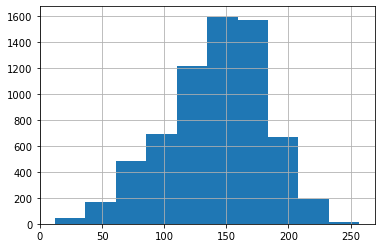

In [118]:
data_df[data_df['Sentiment_numerical'] == 2]["Tweet_Length"].hist()

In [39]:
data_df['message_tokenized']

0                                                       []
1        [advice, Talk, neighbours, family, exchange, p...
2        [Coronavirus, Australia, Woolworths, give, eld...
3        [food, stock, one, empty, PLEASE, panic, ENOUG...
4        [ready, go, supermarket, COVID19, outbreak, pa...
                               ...                        
41152    [Airline, pilots, offering, stock, supermarket...
41153    [Response, complaint, provided, citing, COVID,...
41154    [know, getting, tough, rationing, toilet, pape...
41155    [wrong, smell, hand, sanitizer, starting, turn...
41156    [Well, new, used, Rift, going, 700, 00, Amazon...
Name: message_tokenized, Length: 41159, dtype: object

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,retweeted_from,mentions,hashtags,links,...,message_tokens_lemmatized,Sentiment_numerical,vader_dict,vader_neg,vader_neu,vader_pos,vader_compound,afinn_score,lemmatized_message,Tweet_Length
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,[],[],[],[],...,"[advice, talk, neighbour, family, exchange, ph...",1.0,"{'neg': 0.0, 'neu': 0.923, 'pos': 0.077, 'comp...",0.000,0.923,0.077,0.2500,1.0,advice talk neighbour family exchange phone nu...,187
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,[],[],[],['https://t.co/bInCA9Vp8P'],...,"[coronavirus, australia, woolworths, give, eld...",1.0,"{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'comp...",0.000,0.812,0.188,0.4588,0.0,coronavirus australia woolworths give elderly ...,99
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,[],[],"['COVID19france', 'COVID_19', 'COVID19', 'coro...",['https://t.co/zrlG0Z520j'],...,"[food, stock, one, empty, please, panic, enoug...",1.0,"{'neg': 0.101, 'neu': 0.735, 'pos': 0.164, 'co...",0.101,0.735,0.164,0.4824,0.0,food stock one empty please panic enough food ...,174
5,3804,48756,"ÜT: 36.319708,-82.363649",16-03-2020,As news of the regions first confirmed COVID-...,Positive,[],['Tim_Dodson'],[],['https://t.co/cfXch7a2lU'],...,"[news, region, first, confirm, covid, 19, case...",1.0,"{'neg': 0.0, 'neu': 0.916, 'pos': 0.084, 'comp...",0.000,0.916,0.084,0.4939,0.0,news region first confirm covid 19 case come s...,161
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive,[],[],['Covid_19'],['https://t.co/ieFDNeHgDO'],...,"[cashier, grocery, store, share, insight, covi...",1.0,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp...",0.000,0.909,0.091,0.4215,0.0,cashier grocery store share insight covid_19 p...,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41140,44939,89891,Pakistan,14-04-2020,Good News! \r\r\nWe'll Soon Announce Our High ...,Positive,[],[],[],"['https://t.co/G0Ri0EGP6M', 'https://t.co/qUQ8...",...,"[good, news, soon, announce, high, tech, g, g,...",1.0,"{'neg': 0.054, 'neu': 0.881, 'pos': 0.065, 'co...",0.054,0.881,0.065,0.1298,3.0,good news soon announce high tech g g online l...,178
41145,44944,89896,"Manhattan, NY",14-04-2020,How exactly are we going to re-open New York C...,Positive,[],[],['coronavirus'],[],...,"[exactly, go, open, new, york, city, still, bu...",1.0,"{'neg': 0.0, 'neu': 0.862, 'pos': 0.138, 'comp...",0.000,0.862,0.138,0.4939,0.0,exactly go open new york city still buy hand s...,66
41146,44945,89897,"Gurgaon, India",14-04-2020,#Gold prices rose to a more than 7-year high t...,Positive,[],[],"['Gold', 'coronavirus', 'safe', 'Spot']",['https://t.co/S8coY5VVgN'],...,"[gold, price, rise, 7, year, high, today, due,...",1.0,"{'neg': 0.0, 'neu': 0.868, 'pos': 0.132, 'comp...",0.000,0.868,0.132,0.7650,9.0,gold price rise 7 year high today due coronavi...,181
41150,44949,89901,OHIO,14-04-2020,I never that wed be in a situation &amp; worl...,Positive,[],[],"['coronavirus', 'StayHome', 'SocialDistancing']",[],...,"[never, situation, world, go, supermarket, pic...",1.0,"{'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp...",0.000,0.878,0.122,0.5106,2.0,never situation world go supermarket pick pack...,124


In [59]:
frequent_terms = utils.getMostCommon(data_df[data_df['Sentiment_numerical'] == 2],100,'message_tokenized')
list(map(list, zip(*frequent_terms)))

[['coronavirus',
  '19',
  'COVID',
  'store',
  'supermarket',
  'grocery',
  'help',
  'food',
  'prices',
  'people',
  'hand',
  'sanitizer',
  'like',
  'workers',
  'shopping',
  'online',
  'consumer',
  'COVID19',
  'safe',
  'need',
  'us',
  'time',
  'get',
  'pandemic',
  'home',
  'Coronavirus',
  'Covid_19',
  'support',
  'Covid',
  'work',
  'keep',
  'free',
  'amp',
  'make',
  'Please',
  'go',
  'local',
  'stock',
  'staff',
  'good',
  'best',
  'Thank',
  'great',
  'going',
  '2',
  'one',
  'please',
  'care',
  'delivery',
  'stay',
  '1',
  'everyone',
  'health',
  'demand',
  'COVID2019',
  'know',
  'working',
  'customers',
  'would',
  'today',
  'see',
  'use',
  'way',
  'many',
  'gt',
  'still',
  'take',
  'retail',
  'employees',
  'due',
  'well',
  'covid',
  'thank',
  'stores',
  'masks',
  'also',
  '3',
  'covid19',
  'new',
  'toiletpaper',
  'spread',
  'Consumer',
  'Stay',
  'business',
  'hands',
  'right',
  'shop',
  'buy',
  'essentia

In [67]:
data_df['mentions']
all_words = []
data_df['mentions'].apply(lambda x: utils.add_words(all_words,x))

0        None
1        None
2        None
3        None
4        None
         ... 
41152    None
41153    None
41154    None
41155    None
41156    None
Name: mentions, Length: 41159, dtype: object

In [113]:
all_words = np.array(all_words)
all_words = all_words[all_words!='']
freq_cnt = np.unique(all_words,return_counts= True)
sorted_indexes = np.argsort(freq_cnt[1])[::-1]


In [118]:
mentions = freq_cnt[0][freq_cnt[1]>1]
freq_cnt[1][freq_cnt[1]>1]

array([31,  2,  4, ...,  3,  3,  5])

In [119]:
mentions = freq_cnt[0][sorted_indexes]
counts = freq_cnt[1][sorted_indexes]

In [122]:
mentions

array(['realDonaldTrump', 'Tesco', 'sainsburys', ..., 'anydoubleyou',
       'anuragbatrayo', '0'], dtype='<U25')

In [124]:
counts

array([248, 185, 161, ...,   1,   1,   1])

In [123]:
mentions[counts>1]

array(['realDonaldTrump', 'Tesco', 'sainsburys', ..., 'AAI_Official',
       'Radiodotcom', 'SenateDems'], dtype='<U25')

In [127]:

data_df.loc[data_df['Sentiment_numerical'] == 1].copy(
)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,retweeted_from,mentions,hashtags,links,...,message_tokens_lemmatized,Sentiment_numerical,vader_dict,vader_neg,vader_neu,vader_pos,vader_compound,afinn_score,lemmatized_message,Tweet_Length
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,[],[],[],[],...,"[advice, talk, neighbour, family, exchange, ph...",1.0,"{'neg': 0.0, 'neu': 0.923, 'pos': 0.077, 'comp...",0.000,0.923,0.077,0.2500,1.0,advice talk neighbour family exchange phone nu...,187
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,[],[],[],['https://t.co/bInCA9Vp8P'],...,"[coronavirus, australia, woolworths, give, eld...",1.0,"{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'comp...",0.000,0.812,0.188,0.4588,0.0,coronavirus australia woolworths give elderly ...,99
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,[],[],"['COVID19france', 'COVID_19', 'COVID19', 'coro...",['https://t.co/zrlG0Z520j'],...,"[food, stock, one, empty, please, panic, enoug...",1.0,"{'neg': 0.101, 'neu': 0.735, 'pos': 0.164, 'co...",0.101,0.735,0.164,0.4824,0.0,food stock one empty please panic enough food ...,174
5,3804,48756,"ÜT: 36.319708,-82.363649",16-03-2020,As news of the regions first confirmed COVID-...,Positive,[],[Tim_Dodson],[],['https://t.co/cfXch7a2lU'],...,"[news, region, first, confirm, covid, 19, case...",1.0,"{'neg': 0.0, 'neu': 0.916, 'pos': 0.084, 'comp...",0.000,0.916,0.084,0.4939,0.0,news region first confirm covid 19 case come s...,161
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive,[],[],['Covid_19'],['https://t.co/ieFDNeHgDO'],...,"[cashier, grocery, store, share, insight, covi...",1.0,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp...",0.000,0.909,0.091,0.4215,0.0,cashier grocery store share insight covid_19 p...,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41140,44939,89891,Pakistan,14-04-2020,Good News! \r\r\nWe'll Soon Announce Our High ...,Positive,[],[],[],"['https://t.co/G0Ri0EGP6M', 'https://t.co/qUQ8...",...,"[good, news, soon, announce, high, tech, g, g,...",1.0,"{'neg': 0.054, 'neu': 0.881, 'pos': 0.065, 'co...",0.054,0.881,0.065,0.1298,3.0,good news soon announce high tech g g online l...,178
41145,44944,89896,"Manhattan, NY",14-04-2020,How exactly are we going to re-open New York C...,Positive,[],[],['coronavirus'],[],...,"[exactly, go, open, new, york, city, still, bu...",1.0,"{'neg': 0.0, 'neu': 0.862, 'pos': 0.138, 'comp...",0.000,0.862,0.138,0.4939,0.0,exactly go open new york city still buy hand s...,66
41146,44945,89897,"Gurgaon, India",14-04-2020,#Gold prices rose to a more than 7-year high t...,Positive,[],[],"['Gold', 'coronavirus', 'safe', 'Spot']",['https://t.co/S8coY5VVgN'],...,"[gold, price, rise, 7, year, high, today, due,...",1.0,"{'neg': 0.0, 'neu': 0.868, 'pos': 0.132, 'comp...",0.000,0.868,0.132,0.7650,9.0,gold price rise 7 year high today due coronavi...,181
41150,44949,89901,OHIO,14-04-2020,I never that wed be in a situation &amp; worl...,Positive,[],[],"['coronavirus', 'StayHome', 'SocialDistancing']",[],...,"[never, situation, world, go, supermarket, pic...",1.0,"{'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp...",0.000,0.878,0.122,0.5106,2.0,never situation world go supermarket pick pack...,124
